In [69]:
#from roboflow import Roboflow
#rf = Roboflow(api_key="Z4mFtu232oWID8Vtcntw")
#project = rf.workspace("testsew").project("box-counting-dqcyf")
#version = project.version(5)
#dataset = version.download("coco")

In [70]:
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
import os
import numpy as np
import pandas as pd

In [71]:
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import cv2
from pycocotools.coco import COCO
class CustomDataset(datasets.VisionDataset):
    def __init__(self, root, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms)
        self.coco = COCO(os.path.join(root, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [72]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [73]:
#A quoi ca sert ??
def collate_fn(batch):
    return tuple(zip(*batch))

In [95]:
train_dir = '../Box-Counting-5/train'
test_dir = '../Box-Counting-5/test'
valid_dir = '../Box-Counting-5/valid'

# Define datasets and dataloaders for train, test, and validation
train_dataset = CustomDataset(root=train_dir, transforms=get_transforms(True))
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=4, collate_fn=collate_fn)

test_dataset = CustomDataset(root=test_dir, transforms=get_transforms())
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=4)

valid_dataset = CustomDataset(root=valid_dir, transforms=get_transforms())
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False, num_workers=4)


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [96]:
from functools import partial
from torchvision.models.detection import _utils as det_utils
from torchvision.models.detection.ssdlite import SSDLiteClassificationHead
    
model = torchvision.models.detection.ssd300_vgg16(weights='DEFAULT')

in_channels = det_utils.retrieve_out_channels(model.backbone, (320, 320))
num_anchors = model.anchor_generator.num_anchors_per_location()
norm_layer  = partial(torch.nn.BatchNorm2d, eps=0.001, momentum=0.03)
num_classes = 4 + 1 # 4 classes + background
model.head.classification_head = SSDLiteClassificationHead(in_channels, num_anchors, num_classes, norm_layer)


## Test avec une seul image

In [97]:
images,targets = next(iter(train_dataloader))
images = list(image for image in images)
targets = [{k:v for k, v in t.items()} for t in targets]
output = model(images, targets) # just make sure this runs without error


In [98]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.001, momentum=0.9, nesterov=True, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

device is cuda:0


100%|██████████| 26/26 [00:04<00:00,  6.02it/s]


Epoch 0, lr: 0.001000, loss: 5.511452, classification: 4.653059, bbox_regression: 0.858392,


100%|██████████| 26/26 [00:04<00:00,  6.06it/s]


Epoch 1, lr: 0.001000, loss: 5.061929, classification: 4.249524, bbox_regression: 0.812405,


100%|██████████| 26/26 [00:04<00:00,  5.99it/s]


Epoch 2, lr: 0.001000, loss: 4.612129, classification: 3.839639, bbox_regression: 0.772490,


100%|██████████| 26/26 [00:04<00:00,  6.00it/s]


Epoch 3, lr: 0.001000, loss: 4.181213, classification: 3.477258, bbox_regression: 0.703955,


100%|██████████| 26/26 [00:04<00:00,  6.07it/s]


Epoch 4, lr: 0.001000, loss: 3.696803, classification: 3.099601, bbox_regression: 0.597202,


100%|██████████| 26/26 [00:04<00:00,  6.07it/s]


Epoch 5, lr: 0.001000, loss: 3.444614, classification: 2.807912, bbox_regression: 0.636702,


100%|██████████| 26/26 [00:04<00:00,  5.98it/s]


Epoch 6, lr: 0.001000, loss: 3.237323, classification: 2.700310, bbox_regression: 0.537013,


100%|██████████| 26/26 [00:04<00:00,  6.01it/s]


Epoch 7, lr: 0.001000, loss: 2.983466, classification: 2.494583, bbox_regression: 0.488883,


100%|██████████| 26/26 [00:04<00:00,  6.02it/s]


Epoch 8, lr: 0.001000, loss: 2.898046, classification: 2.374574, bbox_regression: 0.523473,


100%|██████████| 26/26 [00:04<00:00,  5.96it/s]


Epoch 9, lr: 0.001000, loss: 2.773317, classification: 2.341084, bbox_regression: 0.432234,


100%|██████████| 26/26 [00:04<00:00,  6.02it/s]


Epoch 10, lr: 0.001000, loss: 2.799400, classification: 2.276383, bbox_regression: 0.523017,


100%|██████████| 26/26 [00:04<00:00,  6.11it/s]


Epoch 11, lr: 0.001000, loss: 2.313312, classification: 1.985029, bbox_regression: 0.328283,


100%|██████████| 26/26 [00:04<00:00,  6.02it/s]


Epoch 12, lr: 0.001000, loss: 2.374069, classification: 1.945972, bbox_regression: 0.428097,


100%|██████████| 26/26 [00:04<00:00,  6.04it/s]


Epoch 13, lr: 0.001000, loss: 2.340884, classification: 1.886150, bbox_regression: 0.454734,


100%|██████████| 26/26 [00:04<00:00,  6.03it/s]


Epoch 14, lr: 0.001000, loss: 2.208255, classification: 1.796059, bbox_regression: 0.412195,


100%|██████████| 26/26 [00:04<00:00,  6.07it/s]


Epoch 15, lr: 0.001000, loss: 2.141056, classification: 1.721014, bbox_regression: 0.420042,


100%|██████████| 26/26 [00:04<00:00,  6.03it/s]


Epoch 16, lr: 0.001000, loss: 2.125510, classification: 1.693018, bbox_regression: 0.432492,


100%|██████████| 26/26 [00:04<00:00,  6.06it/s]


Epoch 17, lr: 0.001000, loss: 1.779230, classification: 1.471982, bbox_regression: 0.307248,


100%|██████████| 26/26 [00:04<00:00,  6.04it/s]


Epoch 18, lr: 0.001000, loss: 1.960282, classification: 1.590503, bbox_regression: 0.369780,


100%|██████████| 26/26 [00:04<00:00,  6.01it/s]


Epoch 19, lr: 0.001000, loss: 1.890420, classification: 1.494256, bbox_regression: 0.396164,


100%|██████████| 26/26 [00:04<00:00,  6.02it/s]


Epoch 20, lr: 0.001000, loss: 1.636030, classification: 1.284733, bbox_regression: 0.351298,


100%|██████████| 26/26 [00:04<00:00,  5.99it/s]


Epoch 21, lr: 0.001000, loss: 1.606353, classification: 1.265154, bbox_regression: 0.341199,


100%|██████████| 26/26 [00:04<00:00,  6.06it/s]


Epoch 22, lr: 0.001000, loss: 1.519761, classification: 1.234794, bbox_regression: 0.284967,


100%|██████████| 26/26 [00:04<00:00,  5.98it/s]


Epoch 23, lr: 0.001000, loss: 1.431729, classification: 1.161666, bbox_regression: 0.270064,


100%|██████████| 26/26 [00:04<00:00,  6.01it/s]


Epoch 24, lr: 0.001000, loss: 1.246675, classification: 1.026711, bbox_regression: 0.219963,


100%|██████████| 26/26 [00:04<00:00,  6.03it/s]


Epoch 25, lr: 0.001000, loss: 1.265707, classification: 1.006087, bbox_regression: 0.259620,


100%|██████████| 26/26 [00:04<00:00,  5.99it/s]


Epoch 26, lr: 0.001000, loss: 1.362320, classification: 1.090116, bbox_regression: 0.272204,


100%|██████████| 26/26 [00:04<00:00,  6.03it/s]


Epoch 27, lr: 0.001000, loss: 1.192795, classification: 0.920949, bbox_regression: 0.271846,


100%|██████████| 26/26 [00:04<00:00,  6.02it/s]


Epoch 28, lr: 0.001000, loss: 1.331472, classification: 1.052450, bbox_regression: 0.279022,


100%|██████████| 26/26 [00:04<00:00,  6.00it/s]


Epoch 29, lr: 0.001000, loss: 1.038387, classification: 0.816007, bbox_regression: 0.222380,


100%|██████████| 26/26 [00:04<00:00,  6.00it/s]


Epoch 30, lr: 0.001000, loss: 1.279267, classification: 0.986001, bbox_regression: 0.293266,


100%|██████████| 26/26 [00:04<00:00,  5.96it/s]


Epoch 31, lr: 0.001000, loss: 1.040972, classification: 0.814387, bbox_regression: 0.226585,


100%|██████████| 26/26 [00:04<00:00,  6.03it/s]


Epoch 32, lr: 0.001000, loss: 1.115335, classification: 0.845523, bbox_regression: 0.269812,


100%|██████████| 26/26 [00:04<00:00,  5.99it/s]


Epoch 33, lr: 0.001000, loss: 0.989094, classification: 0.746468, bbox_regression: 0.242626,


100%|██████████| 26/26 [00:04<00:00,  5.99it/s]


Epoch 34, lr: 0.001000, loss: 0.913659, classification: 0.693659, bbox_regression: 0.220000,


100%|██████████| 26/26 [00:04<00:00,  6.03it/s]


Epoch 35, lr: 0.001000, loss: 0.926111, classification: 0.718542, bbox_regression: 0.207569,


100%|██████████| 26/26 [00:04<00:00,  6.06it/s]


Epoch 36, lr: 0.001000, loss: 0.793466, classification: 0.604992, bbox_regression: 0.188474,


100%|██████████| 26/26 [00:04<00:00,  5.98it/s]


Epoch 37, lr: 0.001000, loss: 1.013354, classification: 0.768357, bbox_regression: 0.244997,


100%|██████████| 26/26 [00:04<00:00,  6.04it/s]


Epoch 38, lr: 0.001000, loss: 0.955221, classification: 0.710623, bbox_regression: 0.244598,


100%|██████████| 26/26 [00:04<00:00,  6.03it/s]


Epoch 39, lr: 0.001000, loss: 0.847029, classification: 0.636574, bbox_regression: 0.210455,


100%|██████████| 26/26 [00:04<00:00,  6.06it/s]


Epoch 40, lr: 0.001000, loss: 0.803364, classification: 0.611861, bbox_regression: 0.191503,


100%|██████████| 26/26 [00:04<00:00,  6.06it/s]


Epoch 41, lr: 0.001000, loss: 0.810245, classification: 0.616646, bbox_regression: 0.193599,


100%|██████████| 26/26 [00:04<00:00,  6.05it/s]


Epoch 42, lr: 0.001000, loss: 0.693622, classification: 0.518066, bbox_regression: 0.175556,


100%|██████████| 26/26 [00:04<00:00,  5.95it/s]


Epoch 43, lr: 0.001000, loss: 0.750040, classification: 0.580230, bbox_regression: 0.169810,


100%|██████████| 26/26 [00:04<00:00,  5.97it/s]


Epoch 44, lr: 0.001000, loss: 0.548261, classification: 0.417459, bbox_regression: 0.130802,


100%|██████████| 26/26 [00:04<00:00,  5.96it/s]


Epoch 45, lr: 0.001000, loss: 0.676261, classification: 0.508968, bbox_regression: 0.167293,


100%|██████████| 26/26 [00:04<00:00,  5.95it/s]


Epoch 46, lr: 0.001000, loss: 0.744974, classification: 0.536843, bbox_regression: 0.208132,


100%|██████████| 26/26 [00:04<00:00,  6.04it/s]


Epoch 47, lr: 0.001000, loss: 0.717745, classification: 0.518442, bbox_regression: 0.199303,


100%|██████████| 26/26 [00:04<00:00,  6.02it/s]


Epoch 48, lr: 0.001000, loss: 0.704172, classification: 0.492516, bbox_regression: 0.211656,


100%|██████████| 26/26 [00:04<00:00,  5.96it/s]


Epoch 49, lr: 0.001000, loss: 0.754263, classification: 0.572659, bbox_regression: 0.181604,


100%|██████████| 26/26 [00:04<00:00,  6.02it/s]


Epoch 50, lr: 0.001000, loss: 0.640009, classification: 0.477527, bbox_regression: 0.162483,


100%|██████████| 26/26 [00:04<00:00,  5.98it/s]


Epoch 51, lr: 0.001000, loss: 0.655306, classification: 0.496420, bbox_regression: 0.158886,


100%|██████████| 26/26 [00:04<00:00,  6.01it/s]


Epoch 52, lr: 0.001000, loss: 0.562954, classification: 0.418084, bbox_regression: 0.144870,


100%|██████████| 26/26 [00:04<00:00,  6.01it/s]


Epoch 53, lr: 0.001000, loss: 0.644118, classification: 0.476832, bbox_regression: 0.167286,


100%|██████████| 26/26 [00:04<00:00,  5.98it/s]


Epoch 54, lr: 0.001000, loss: 0.735955, classification: 0.552170, bbox_regression: 0.183785,


100%|██████████| 26/26 [00:04<00:00,  6.06it/s]


Epoch 55, lr: 0.001000, loss: 0.527254, classification: 0.384017, bbox_regression: 0.143237,


100%|██████████| 26/26 [00:04<00:00,  6.02it/s]


Epoch 56, lr: 0.001000, loss: 0.574942, classification: 0.404396, bbox_regression: 0.170546,


100%|██████████| 26/26 [00:04<00:00,  5.94it/s]


Epoch 57, lr: 0.001000, loss: 0.662562, classification: 0.494363, bbox_regression: 0.168199,


100%|██████████| 26/26 [00:04<00:00,  5.98it/s]


Epoch 58, lr: 0.001000, loss: 0.613514, classification: 0.457378, bbox_regression: 0.156136,


100%|██████████| 26/26 [00:04<00:00,  5.97it/s]


Epoch 59, lr: 0.001000, loss: 0.532758, classification: 0.383363, bbox_regression: 0.149395,


100%|██████████| 26/26 [00:04<00:00,  6.04it/s]


Epoch 60, lr: 0.001000, loss: 0.590102, classification: 0.412240, bbox_regression: 0.177862,


100%|██████████| 26/26 [00:04<00:00,  5.97it/s]


Epoch 61, lr: 0.001000, loss: 0.520298, classification: 0.358192, bbox_regression: 0.162106,


100%|██████████| 26/26 [00:04<00:00,  5.98it/s]


Epoch 62, lr: 0.001000, loss: 0.470172, classification: 0.344236, bbox_regression: 0.125936,


100%|██████████| 26/26 [00:04<00:00,  6.05it/s]


Epoch 63, lr: 0.001000, loss: 0.444792, classification: 0.303315, bbox_regression: 0.141477,


100%|██████████| 26/26 [00:04<00:00,  6.03it/s]


Epoch 64, lr: 0.001000, loss: 0.427675, classification: 0.306983, bbox_regression: 0.120692,


100%|██████████| 26/26 [00:04<00:00,  6.00it/s]


Epoch 65, lr: 0.001000, loss: 0.419545, classification: 0.301718, bbox_regression: 0.117828,


100%|██████████| 26/26 [00:04<00:00,  5.96it/s]


Epoch 66, lr: 0.001000, loss: 0.428716, classification: 0.302836, bbox_regression: 0.125880,


100%|██████████| 26/26 [00:04<00:00,  5.98it/s]


Epoch 67, lr: 0.001000, loss: 0.356935, classification: 0.264293, bbox_regression: 0.092642,


100%|██████████| 26/26 [00:04<00:00,  5.99it/s]


Epoch 68, lr: 0.001000, loss: 0.382187, classification: 0.283694, bbox_regression: 0.098494,


100%|██████████| 26/26 [00:04<00:00,  6.03it/s]


Epoch 69, lr: 0.001000, loss: 0.284495, classification: 0.206705, bbox_regression: 0.077790,


100%|██████████| 26/26 [00:04<00:00,  5.99it/s]


Epoch 70, lr: 0.001000, loss: 0.369544, classification: 0.261862, bbox_regression: 0.107681,


100%|██████████| 26/26 [00:04<00:00,  5.99it/s]


Epoch 71, lr: 0.001000, loss: 0.549792, classification: 0.396783, bbox_regression: 0.153009,


100%|██████████| 26/26 [00:04<00:00,  5.99it/s]


Epoch 72, lr: 0.001000, loss: 0.413613, classification: 0.270331, bbox_regression: 0.143282,


100%|██████████| 26/26 [00:04<00:00,  5.97it/s]


Epoch 73, lr: 0.001000, loss: 0.309242, classification: 0.217147, bbox_regression: 0.092095,


100%|██████████| 26/26 [00:04<00:00,  6.02it/s]


Epoch 74, lr: 0.001000, loss: 0.424694, classification: 0.302786, bbox_regression: 0.121908,


100%|██████████| 26/26 [00:04<00:00,  5.99it/s]


Epoch 75, lr: 0.001000, loss: 0.422966, classification: 0.299761, bbox_regression: 0.123205,


100%|██████████| 26/26 [00:04<00:00,  6.02it/s]


Epoch 76, lr: 0.001000, loss: 0.313502, classification: 0.214333, bbox_regression: 0.099169,


100%|██████████| 26/26 [00:04<00:00,  6.02it/s]


Epoch 77, lr: 0.001000, loss: 0.293625, classification: 0.198666, bbox_regression: 0.094959,


100%|██████████| 26/26 [00:04<00:00,  6.05it/s]


Epoch 78, lr: 0.001000, loss: 0.310480, classification: 0.206338, bbox_regression: 0.104142,


100%|██████████| 26/26 [00:04<00:00,  6.01it/s]


Epoch 79, lr: 0.001000, loss: 0.313201, classification: 0.235426, bbox_regression: 0.077775,


100%|██████████| 26/26 [00:04<00:00,  5.99it/s]


Epoch 80, lr: 0.001000, loss: 0.254155, classification: 0.173408, bbox_regression: 0.080747,


100%|██████████| 26/26 [00:04<00:00,  6.03it/s]


Epoch 81, lr: 0.001000, loss: 0.297798, classification: 0.205598, bbox_regression: 0.092199,


100%|██████████| 26/26 [00:04<00:00,  6.01it/s]


Epoch 82, lr: 0.001000, loss: 0.330639, classification: 0.221014, bbox_regression: 0.109625,


100%|██████████| 26/26 [00:04<00:00,  5.98it/s]


Epoch 83, lr: 0.001000, loss: 0.244315, classification: 0.171513, bbox_regression: 0.072802,


100%|██████████| 26/26 [00:04<00:00,  6.01it/s]


Epoch 84, lr: 0.001000, loss: 0.381218, classification: 0.282117, bbox_regression: 0.099100,


100%|██████████| 26/26 [00:04<00:00,  5.94it/s]


Epoch 85, lr: 0.001000, loss: 0.342722, classification: 0.240685, bbox_regression: 0.102036,


100%|██████████| 26/26 [00:04<00:00,  5.97it/s]


Epoch 86, lr: 0.001000, loss: 0.307351, classification: 0.219514, bbox_regression: 0.087837,


100%|██████████| 26/26 [00:04<00:00,  5.99it/s]


Epoch 87, lr: 0.001000, loss: 0.303366, classification: 0.202866, bbox_regression: 0.100499,


100%|██████████| 26/26 [00:04<00:00,  5.97it/s]


Epoch 88, lr: 0.001000, loss: 0.345539, classification: 0.233923, bbox_regression: 0.111616,


100%|██████████| 26/26 [00:04<00:00,  6.02it/s]


Epoch 89, lr: 0.001000, loss: 0.279363, classification: 0.182319, bbox_regression: 0.097044,


100%|██████████| 26/26 [00:04<00:00,  5.96it/s]


Epoch 90, lr: 0.001000, loss: 0.258553, classification: 0.163187, bbox_regression: 0.095366,


100%|██████████| 26/26 [00:04<00:00,  6.05it/s]


Epoch 91, lr: 0.001000, loss: 0.292529, classification: 0.206011, bbox_regression: 0.086518,


100%|██████████| 26/26 [00:04<00:00,  5.93it/s]


Epoch 92, lr: 0.001000, loss: 0.253857, classification: 0.177043, bbox_regression: 0.076814,


100%|██████████| 26/26 [00:04<00:00,  5.97it/s]


Epoch 93, lr: 0.001000, loss: 0.347776, classification: 0.229521, bbox_regression: 0.118255,


100%|██████████| 26/26 [00:04<00:00,  6.00it/s]


Epoch 94, lr: 0.001000, loss: 0.248738, classification: 0.154172, bbox_regression: 0.094567,


100%|██████████| 26/26 [00:04<00:00,  6.01it/s]


Epoch 95, lr: 0.001000, loss: 0.252000, classification: 0.159643, bbox_regression: 0.092357,


100%|██████████| 26/26 [00:04<00:00,  6.03it/s]


Epoch 96, lr: 0.001000, loss: 0.258662, classification: 0.168426, bbox_regression: 0.090236,


100%|██████████| 26/26 [00:04<00:00,  5.99it/s]


Epoch 97, lr: 0.001000, loss: 0.270826, classification: 0.183428, bbox_regression: 0.087397,


100%|██████████| 26/26 [00:04<00:00,  6.03it/s]


Epoch 98, lr: 0.001000, loss: 0.256389, classification: 0.170839, bbox_regression: 0.085549,


100%|██████████| 26/26 [00:04<00:00,  5.95it/s]


Epoch 99, lr: 0.001000, loss: 0.183397, classification: 0.121577, bbox_regression: 0.061821,


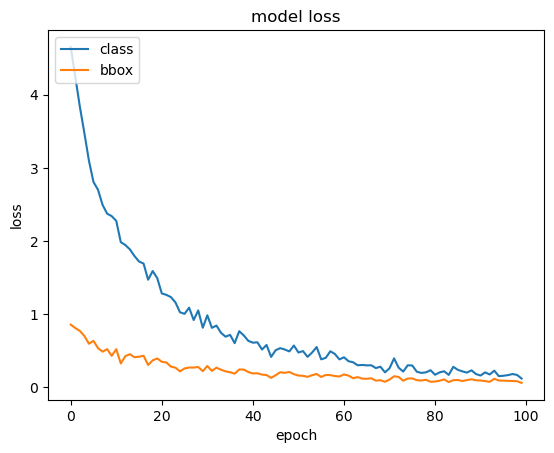

In [100]:
from tqdm import tqdm # progress bar

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is {}".format(device))

num_epochs = 100
avg_class_loss = []
avg_bbox_loss = []

# Train the model
for epoch in range(num_epochs):
    
    model = model.to(device)
    model.train()

    all_losses = []
    all_losses_dict = []
    
    for images, target in tqdm(train_dataloader):
        optimizer.zero_grad()
        
        images,targets = next(iter(train_dataloader))
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()}
        loss_value = losses.item()
        
        all_losses.append(loss_value)
        all_losses_dict.append(loss_dict_append)

        losses.backward()
        optimizer.step()

    all_losses_dict = pd.DataFrame(all_losses_dict) # for printing
    avg_class_loss.append(all_losses_dict['classification'].mean())
    avg_bbox_loss.append(all_losses_dict['bbox_regression'].mean())
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, classification: {:.6f}, bbox_regression: {:.6f},".format(
            epoch, optimizer.param_groups[0]['lr'],
            np.mean(all_losses),
            all_losses_dict['classification'].mean(),
            all_losses_dict['bbox_regression'].mean()
        ))

# Affichage des courbes
import matplotlib.pyplot as plt
plt.plot(avg_class_loss)
plt.plot(avg_bbox_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['class', 'bbox'], loc='upper left')
plt.show()

In [101]:
# Save the trained model
torch.save(model.state_dict(), '../Box-Counting-5/fine_tuned_ssd_model.pth')

loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
labels predicted and ground truth tensor([1, 1, 1, 1, 1, 1, 4, 3, 4, 2], device='cuda:0') tensor([1, 1, 1, 1])
['Box4G', 'Box4G', 'Box4G', 'Box4G', 'Box4G', 'Box4G', 'BoxB8', 'BoxB4', 'BoxB8', 'Box8G']
tensor([0.9999, 0.9996, 0.9866, 0.8431, 0.1071, 0.0526, 0.0489, 0.0428, 0.0139,
        0.0135], device='cuda:0')


To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


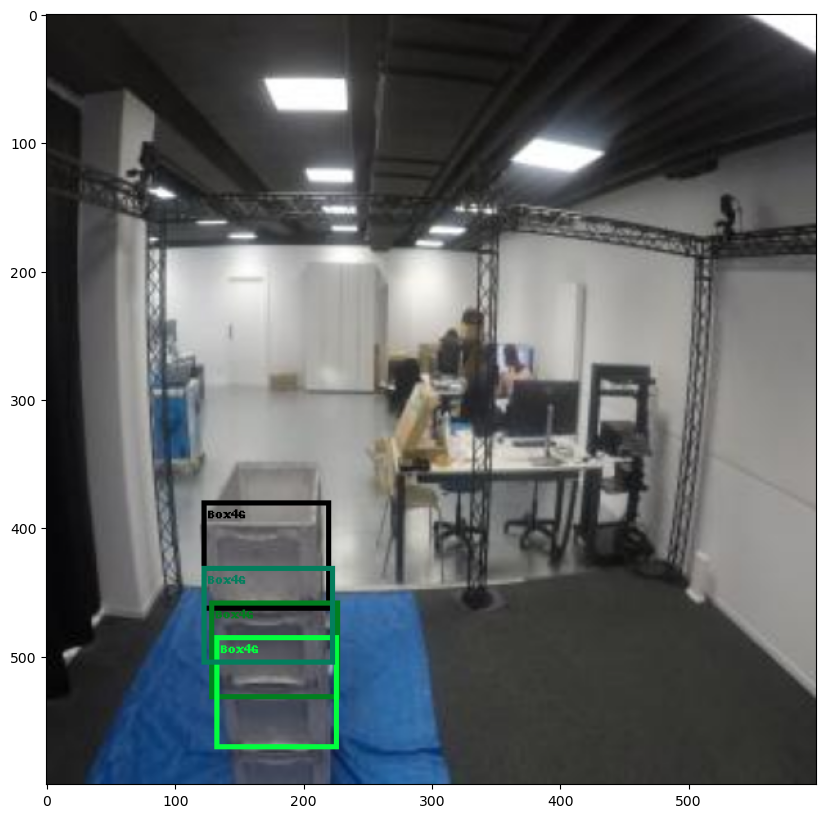

labels predicted and ground truth tensor([1, 1, 1, 1, 2, 2, 1, 3, 3, 1, 3, 1, 4, 2, 4, 4, 3, 3, 4, 2, 2, 2, 3, 4,
        3, 3, 1, 2], device='cuda:0') tensor([1, 1, 1, 1])
['Box4G', 'Box4G', 'Box4G', 'Box4G', 'Box8G', 'Box8G', 'Box4G', 'BoxB4', 'BoxB4', 'Box4G', 'BoxB4', 'Box4G', 'BoxB8', 'Box8G', 'BoxB8', 'BoxB8', 'BoxB4', 'BoxB4', 'BoxB8', 'Box8G', 'Box8G', 'Box8G', 'BoxB4', 'BoxB8', 'BoxB4', 'BoxB4', 'Box4G', 'Box8G']
tensor([1.0000, 0.9992, 0.9978, 0.9962, 0.1492, 0.1447, 0.1440, 0.1417, 0.1389,
        0.1372, 0.1352, 0.1329, 0.1294, 0.1276, 0.1252, 0.1133, 0.0738, 0.0422,
        0.0378, 0.0333, 0.0266, 0.0259, 0.0173, 0.0167, 0.0136, 0.0107, 0.0103,
        0.0101], device='cuda:0')


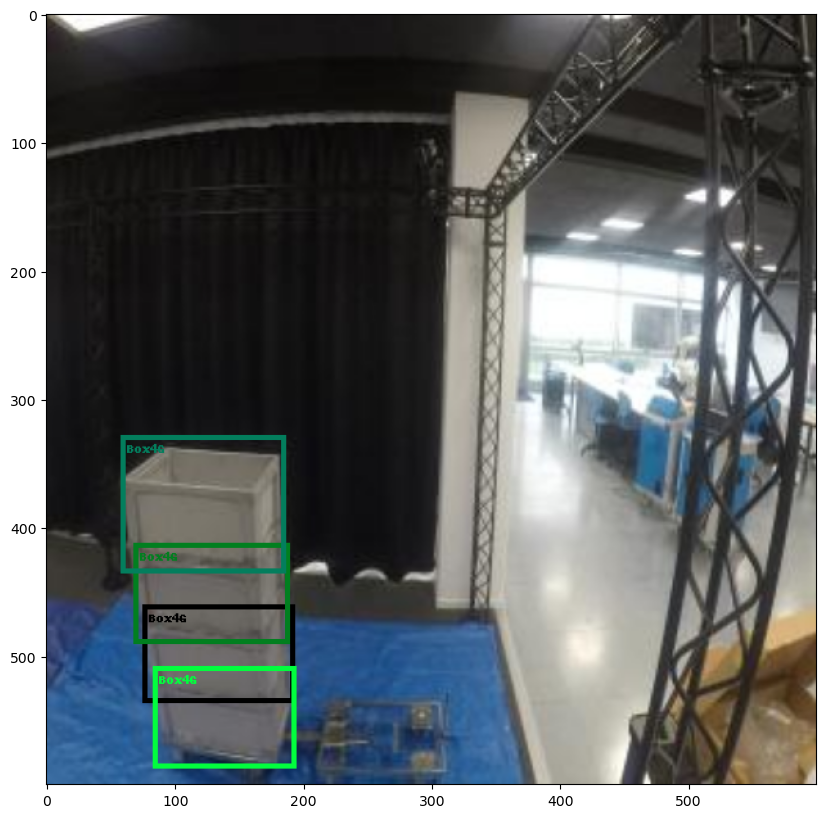

labels predicted and ground truth tensor([3, 3, 3, 3, 2, 1, 2, 4, 3, 1, 3, 3, 1, 4, 2, 4, 3, 3], device='cuda:0') tensor([3, 3, 3, 3])
['BoxB4', 'BoxB4', 'BoxB4', 'BoxB4', 'Box8G', 'Box4G', 'Box8G', 'BoxB8', 'BoxB4', 'Box4G', 'BoxB4', 'BoxB4', 'Box4G', 'BoxB8', 'Box8G', 'BoxB8', 'BoxB4', 'BoxB4']
tensor([0.9998, 0.9997, 0.9996, 0.9994, 0.1335, 0.1331, 0.1311, 0.1300, 0.1298,
        0.1293, 0.1267, 0.1231, 0.1206, 0.1155, 0.1106, 0.1099, 0.0351, 0.0109],
       device='cuda:0')


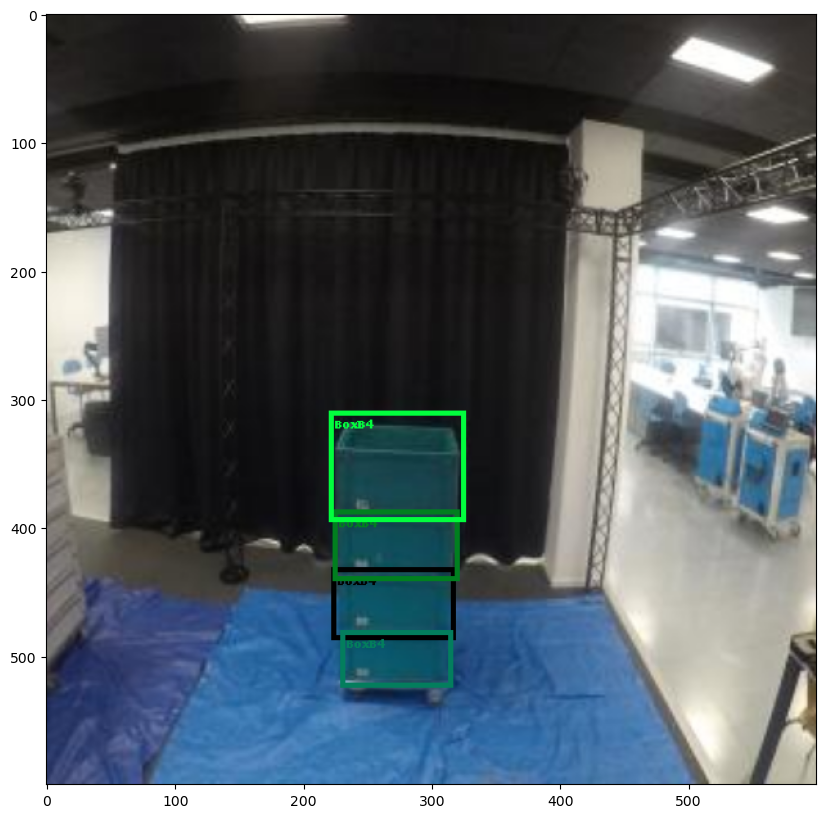

labels predicted and ground truth tensor([1, 1, 1, 1], device='cuda:0') tensor([1, 1, 1, 1])
['Box4G', 'Box4G', 'Box4G', 'Box4G']
tensor([0.9997, 0.9989, 0.9985, 0.9974], device='cuda:0')


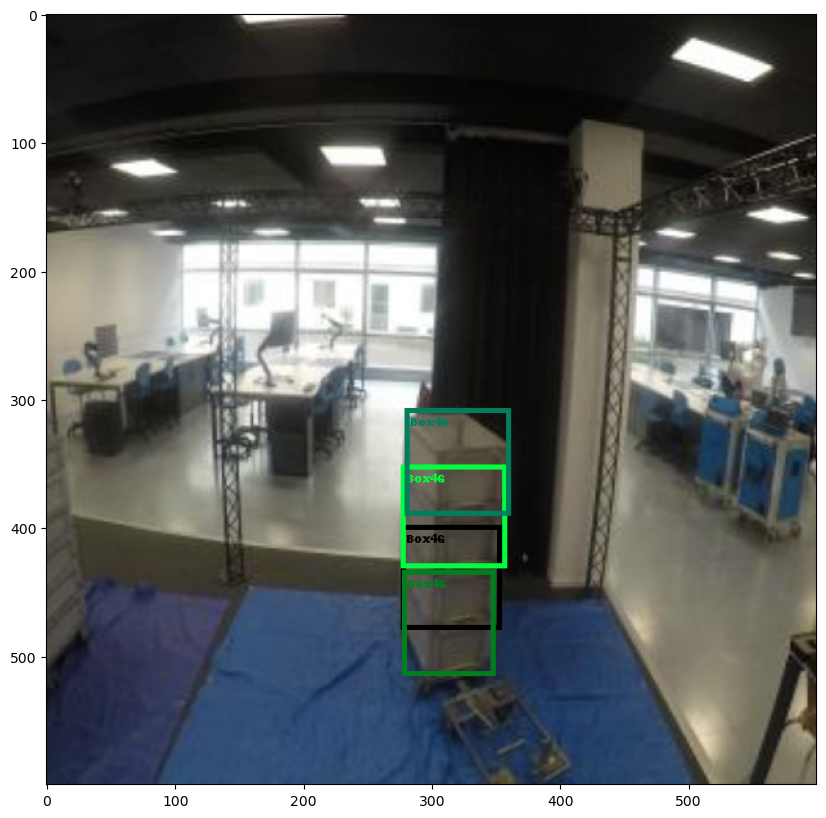

labels predicted and ground truth tensor([3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 3, 4,
        3, 2, 3, 1, 3, 1, 3, 2, 3, 2, 3, 2, 3, 4, 4, 2, 1, 3, 2, 3, 3, 4],
       device='cuda:0') tensor([3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3])
['BoxB4', 'BoxB4', 'BoxB4', 'BoxB4', 'BoxB8', 'BoxB8', 'BoxB8', 'BoxB8', 'BoxB8', 'BoxB8', 'BoxB8', 'Box8G', 'Box8G', 'Box8G', 'Box8G', 'Box8G', 'Box8G', 'Box8G', 'Box8G', 'Box8G', 'Box8G', 'BoxB8', 'BoxB4', 'BoxB8', 'BoxB4', 'Box8G', 'BoxB4', 'Box4G', 'BoxB4', 'Box4G', 'BoxB4', 'Box8G', 'BoxB4', 'Box8G', 'BoxB4', 'Box8G', 'BoxB4', 'BoxB8', 'BoxB8', 'Box8G', 'Box4G', 'BoxB4', 'Box8G', 'BoxB4', 'BoxB4', 'BoxB8']
tensor([1.0000, 0.9999, 0.9999, 0.9999, 0.9996, 0.9996, 0.9996, 0.9996, 0.9995,
        0.9993, 0.9988, 0.9937, 0.9930, 0.9913, 0.9904, 0.9904, 0.9896, 0.9846,
        0.9840, 0.9824, 0.9722, 0.9629, 0.6117, 0.4183, 0.0880, 0.0671, 0.0648,
        0.0584, 0.0440, 0.0401, 0.0364, 0.0276, 0.0270, 0

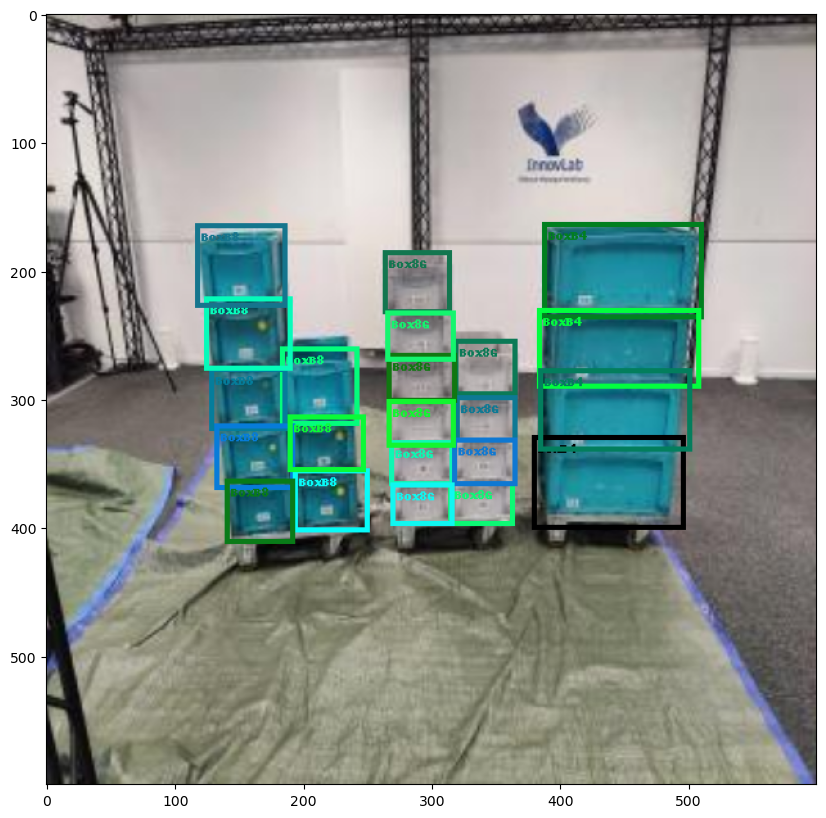

labels predicted and ground truth tensor([3, 3, 3, 3, 1, 1, 3, 1, 2, 2, 1, 1, 3, 3, 4, 3, 2, 3, 4, 4, 1, 3, 1, 3],
       device='cuda:0') tensor([3, 3, 3, 3])
['BoxB4', 'BoxB4', 'BoxB4', 'BoxB4', 'Box4G', 'Box4G', 'BoxB4', 'Box4G', 'Box8G', 'Box8G', 'Box4G', 'Box4G', 'BoxB4', 'BoxB4', 'BoxB8', 'BoxB4', 'Box8G', 'BoxB4', 'BoxB8', 'BoxB8', 'Box4G', 'BoxB4', 'Box4G', 'BoxB4']
tensor([0.9999, 0.9999, 0.9999, 0.9996, 0.0746, 0.0229, 0.0221, 0.0216, 0.0215,
        0.0214, 0.0214, 0.0206, 0.0205, 0.0202, 0.0186, 0.0185, 0.0179, 0.0175,
        0.0165, 0.0153, 0.0138, 0.0137, 0.0112, 0.0110], device='cuda:0')


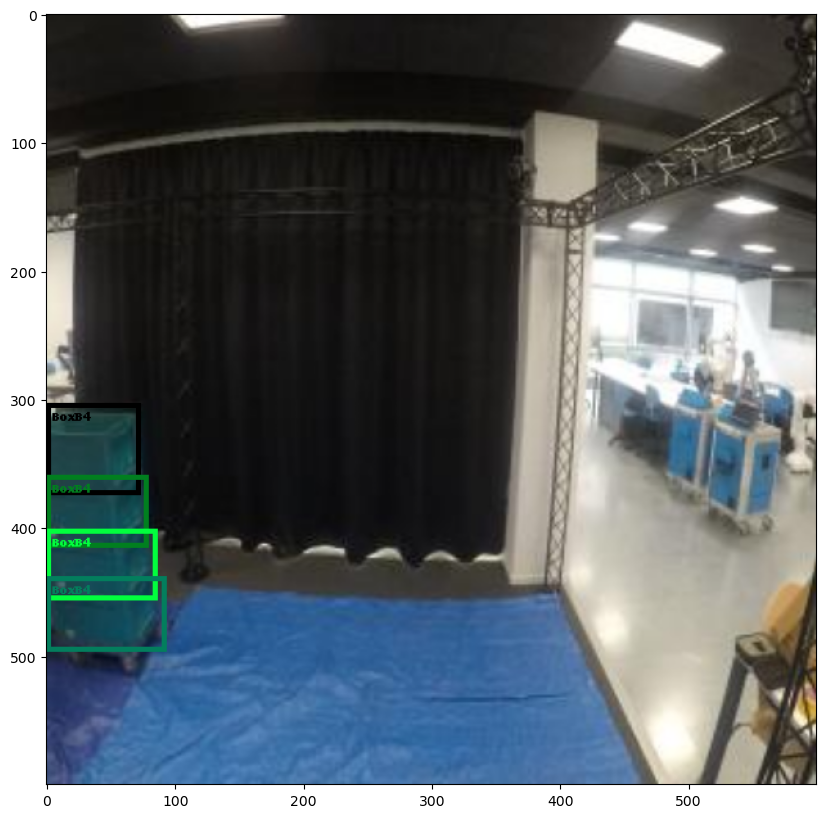

labels predicted and ground truth tensor([3, 3, 3, 3, 3, 3, 1, 2], device='cuda:0') tensor([3, 3, 3, 3])
['BoxB4', 'BoxB4', 'BoxB4', 'BoxB4', 'BoxB4', 'BoxB4', 'Box4G', 'Box8G']
tensor([0.9999, 0.9999, 0.9999, 0.9997, 0.0805, 0.0137, 0.0118, 0.0106],
       device='cuda:0')


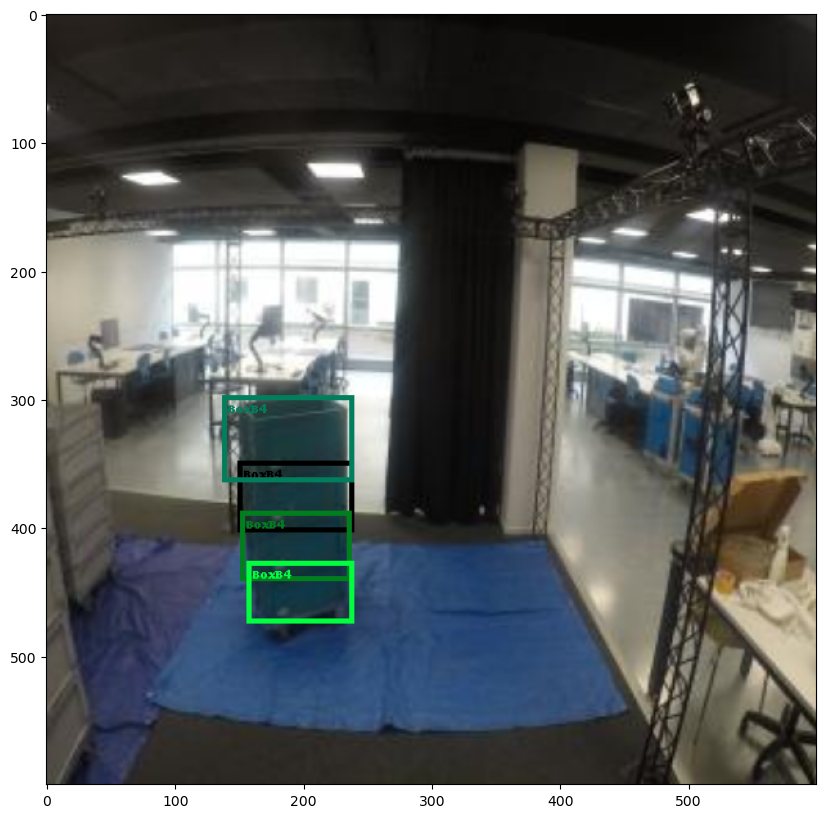

Average Precision score:  0.44845184683799744


In [102]:
import matplotlib.pyplot as plt
from torchvision.utils import draw_bounding_boxes
#Avoir le nom des classes
dataset_path = '../Box-Counting-5'
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
classes = [i[1]['name'] for i in categories.items()]

avg_score = 0

model.eval()
torch.cuda.empty_cache()
for img, target in test_dataset:
    with torch.no_grad():
        prediction = model([img.to(device)])
        pred = prediction[0]
        print("labels predicted and ground truth", pred['labels'], target['labels'])
        print([classes[i] for i in pred['labels'].tolist()])
        print(pred['scores'])


        # Average Precision score for the model
        avg_score += torch.mean(pred['scores']).item()


    img_int = torch.tensor(img * 255, dtype=torch.uint8)
    fig = plt.figure(figsize=(14, 10))
    plt.imshow(draw_bounding_boxes(img_int,
        pred['boxes'][pred['scores'] > 0.8],
        [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
    ).permute(1, 2, 0))

    plt.show()

print("Average Precision score: ", avg_score / len(test_dataset))


Le git permet d'obtenir des fonctions utiles pour l'entraînement et l'évaluation

In [39]:
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 493869, done.
remote: Counting objects: 100% (7479/7479), done.
remote: Compressing objects: 100% (463/463), done.
remote: Total 493869 (delta 7039), reused 7427 (delta 7002), pack-reused 486390
Receiving objects: 100% (493869/493869), 957.29 MiB | 25.22 MiB/s, done.
Resolving deltas: 100% (460274/460274), done.
fatal: not a git repository (or any of the parent directories): .git


In [63]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device is {}".format(device))

# training for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model.to(device), optimizer, train_dataloader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, valid_dataloader, device=device)

# Save the trained model
torch.save(model.state_dict(), '../Box-Counting-5/fine_tuned_ssd_model.pth')

device is cuda:0
Epoch: [0]  [ 0/17]  eta: 0:00:02  lr: 0.000000  loss: 10.7459 (10.7459)  bbox_regression: 1.8733 (1.8733)  classification: 8.8726 (8.8726)  time: 0.1457  data: 0.1004  max mem: 756
Epoch: [0]  [10/17]  eta: 0:00:00  lr: 0.000000  loss: 11.0511 (10.9736)  bbox_regression: 2.0707 (2.0575)  classification: 8.9536 (8.9162)  time: 0.0377  data: 0.0128  max mem: 756
Epoch: [0]  [16/17]  eta: 0:00:00  lr: 0.000000  loss: 11.1158 (11.1023)  bbox_regression: 2.0780 (2.1449)  classification: 9.0397 (8.9574)  time: 0.0332  data: 0.0096  max mem: 756
Epoch: [0] Total time: 0:00:00 (0.0347 s / it)
Epoch: [1]  [ 0/17]  eta: 0:00:02  lr: 0.000000  loss: 11.0903 (11.0903)  bbox_regression: 1.8595 (1.8595)  classification: 9.2308 (9.2308)  time: 0.1291  data: 0.1045  max mem: 756
Epoch: [1]  [10/17]  eta: 0:00:00  lr: 0.000000  loss: 11.0611 (11.0861)  bbox_regression: 2.1896 (2.2032)  classification: 8.9941 (8.8829)  time: 0.0347  data: 0.0125  max mem: 756
Epoch: [1]  [16/17]  eta: 

In [65]:
evaluate(model, test_dataloader, device=device)

creating index...
index created!


RuntimeError: Boolean value of Tensor with more than one value is ambiguous